# Exercises

In [1]:
## General imports
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("../../AchimBrinkop/Neuro-Analysis/01-local_field_potential/code"))
from utils import download_data
import lfp_functions as lf
from scipy import signal
from pywt import scale2frequency
from pywt import cwt
from scipy.signal import butter
from scipy.signal import sosfilt

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
with open('../../AchimBrinkop/Neuro-Analysis/01-local_field_potential/data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


The data contain a little over 600 seconds of recording time. Below we will investigate the first five seconds of the data.

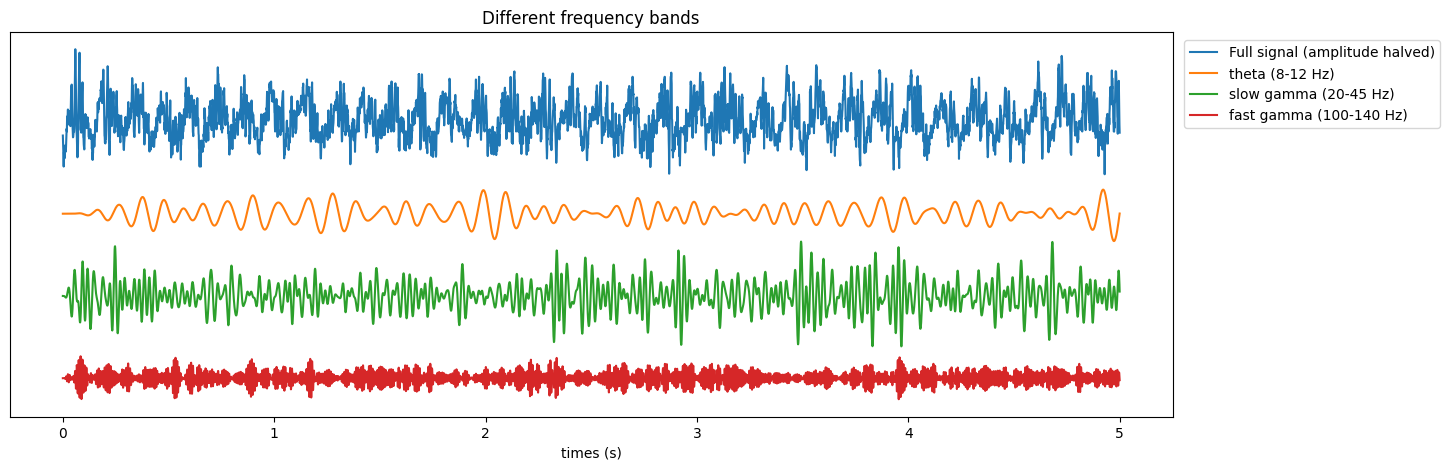

In [3]:
## Filter different frequency bands for the first 5 minutes of the recorded data
plt.figure(figsize=(15,5))
plt.title('Different frequency bands')
plt.plot(np.linspace(0,5,5000),lfp[:5000]/2,label='Full signal (amplitude halved)')
plot_offset = 250
plt.xlabel('times (s)')

# Different frequency bandpass filters
theta_lfp = lf.bandpass_filter(lfp,low_f=8,high_f=12, sampling_rate=sampling_rate)
slow_gamma_lfp = lf.bandpass_filter(lfp,low_f=20,high_f=45, sampling_rate=sampling_rate)
fast_gamma_lfp = lf.bandpass_filter(lfp,low_f=100,high_f=140, sampling_rate=sampling_rate)

plt.plot(np.linspace(0,5,5000),theta_lfp[:5000]-plot_offset,label='theta (8-12 Hz)')
plt.plot(np.linspace(0,5,5000),slow_gamma_lfp[:5000]-2*plot_offset,label = 'slow gamma (20-45 Hz)')
plt.plot(np.linspace(0,5,5000),fast_gamma_lfp[:5000]-3*plot_offset,label = 'fast gamma (100-140 Hz)')

plt.legend(loc=(1.01,0.75))
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.show()

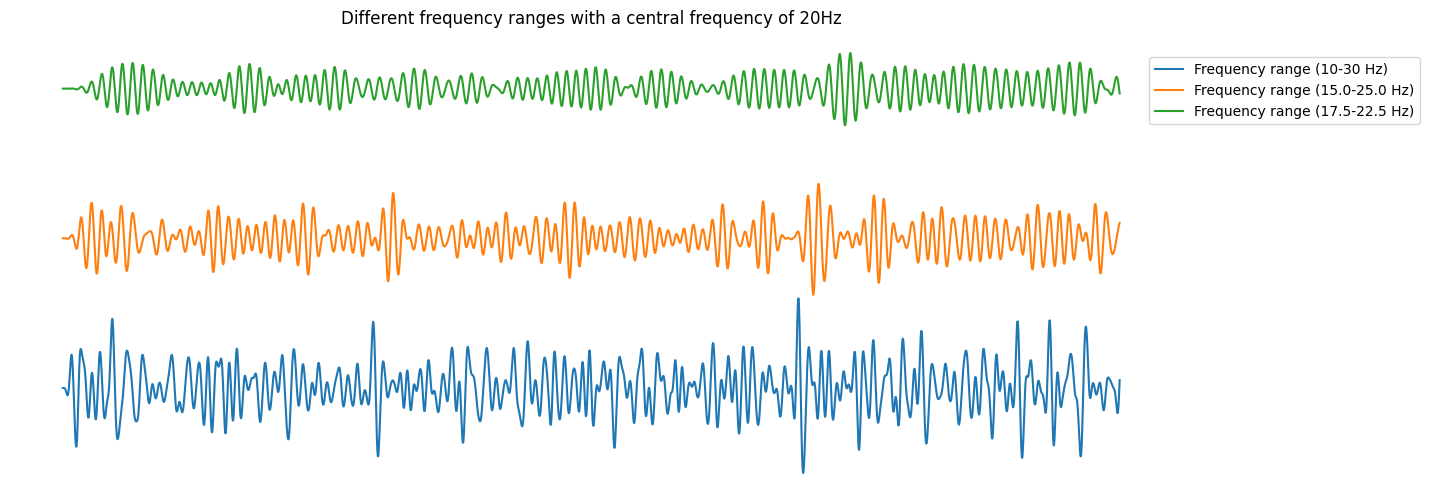

The same frequency bandwidths but with a different central frequency (15 Hz): 


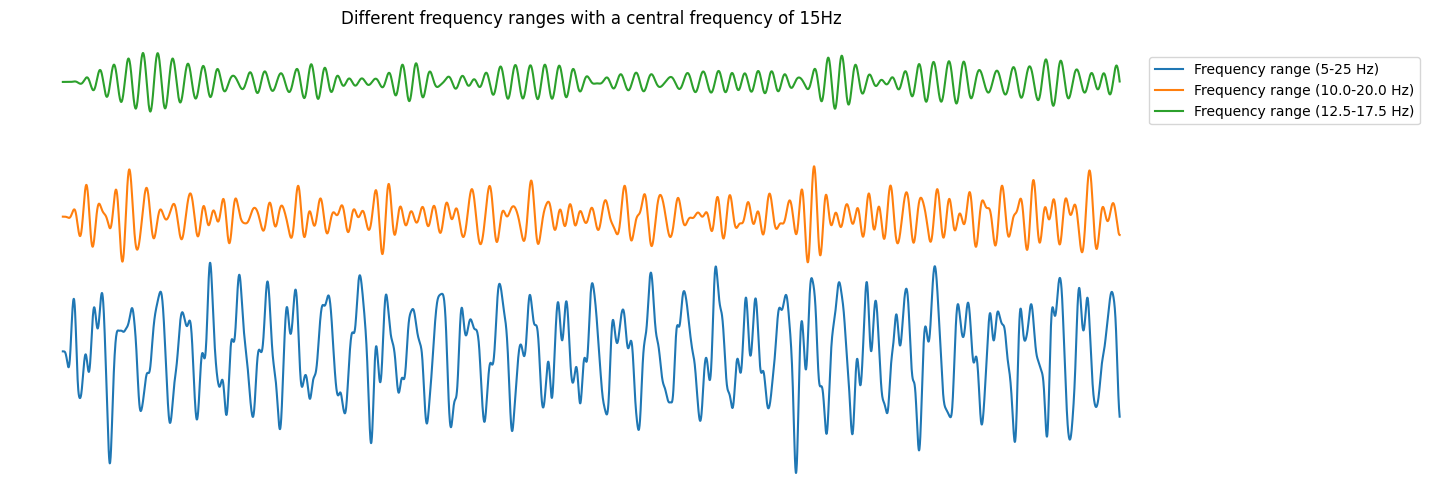

In [5]:
## Bandwith filtering with fixed central frequency
center_freq = 20 # The central frequency
width = 10 # Determines the width of the Frequency range

# Broad bandwith filter
plt.figure(figsize=(15,6))
plt.title(f'Different frequency ranges with a central frequency of {center_freq}Hz')
plot_offset = 250 #to plot the signal on different lines

band1_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width,high_f=center_freq+width, sampling_rate=sampling_rate)
plt.plot(np.linspace(0,5,5000),band1_lfp[:5000],label=f'Frequency range ({center_freq-width}-{center_freq+width} Hz)')

band2_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width/2,high_f=center_freq+width/2, sampling_rate=sampling_rate)
plt.plot(np.linspace(0,5,5000),band2_lfp[:5000]+plot_offset,label=f'Frequency range ({center_freq-width/2}-{center_freq+width/2} Hz)')

band3_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width/4,high_f=center_freq+width/4, sampling_rate=sampling_rate)
plt.plot(np.linspace(0,5,5000),band3_lfp[:5000]+2*plot_offset,label=f'Frequency range ({center_freq-width/4}-{center_freq+width/4} Hz)')

plt.legend(loc=(0.98,0.8))
plt.axis('off')
plt.show()

print('The same frequency bandwidths but with a different central frequency (15 Hz): ')

center_freq = 15 # The central frequency
width = 10 # Determines the width of the Frequency range

# Broad bandwith filter
plt.figure(figsize=(15,6))
plt.title(f'Different frequency ranges with a central frequency of {center_freq}Hz')
plot_offset = 250 #to plot the signal on different lines

band1_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width,high_f=center_freq+width, sampling_rate=sampling_rate)
plt.plot(np.linspace(0,5,5000),band1_lfp[:5000],label=f'Frequency range ({center_freq-width}-{center_freq+width} Hz)')

band2_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width/2,high_f=center_freq+width/2, sampling_rate=sampling_rate)
plt.plot(np.linspace(0,5,5000),band2_lfp[:5000]+plot_offset,label=f'Frequency range ({center_freq-width/2}-{center_freq+width/2} Hz)')

band3_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width/4,high_f=center_freq+width/4, sampling_rate=sampling_rate)
plt.plot(np.linspace(0,5,5000),band3_lfp[:5000]+2*plot_offset,label=f'Frequency range ({center_freq-width/4}-{center_freq+width/4} Hz)')

# band4_lfp = lf.bandpass_filter(lfp,low_f=center_freq-width/10,high_f=center_freq+width/10, sampling_rate=sampling_rate)
# plt.plot(np.linspace(0,5,5000),band4_lfp[:5000]+3*plot_offset,label=f'Frequency range ({center_freq-width/10}-{center_freq+width/10} Hz)')

plt.legend(loc=(0.98,0.8))
plt.axis('off')
plt.show()

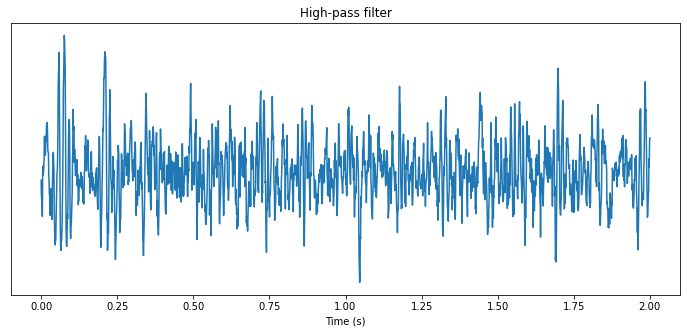

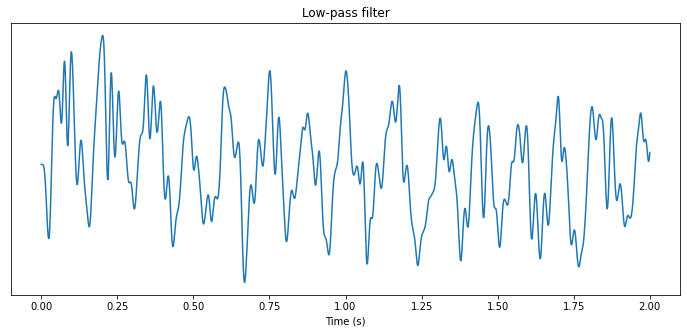

In [5]:
## Determine the computing time of high- and low-pass filters

filter_order = 6 #the higher the order, the sharper the filter frequency response

# Low-pass filter
low_pass = butter(filter_order,[0.1,40],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

# High-pass filter
high_pass = butter(filter_order,[10,499.9],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

plt.figure(figsize=(12,5))
plt.plot(np.linspace(0,2,2000),sosfilt(high_pass,lfp[:2000]))
plt.title('High-pass filter')
plt.xlabel('Time (s)')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(12,5))
plt.plot(np.linspace(0,2,2000),sosfilt(low_pass,lfp[:2000]))
plt.title('Low-pass filter')
plt.xlabel('Time (s)')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.show()

In [6]:
# First apply low-pass filer and then high-pass
print('Time that it takes to first apply low-pass filter and then a high-pass filter:')
%timeit wideband_lfp = sosfilt(high_pass,sosfilt(low_pass, lfp))

# First apply high-pass filer and then low-pass
print('\nTime that it takes to first apply high-pass filter and then a low-pass filter:')
%timeit wideband_lfp = sosfilt(low_pass,sosfilt(high_pass, lfp))

Time that it takes to first apply low-pass filter and then a high-pass filter:
11.8 ms ± 3.06 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Time that it takes to first apply high-pass filter and then a low-pass filter:
11.9 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


__Comments:__
- Figure 1: A signal can be decomposed in seperate signals with different frequency ranges. A signal is a superposition of all the frequencies.
- Figure 2: As the bandwith decreases the frequency bands start to become more of a wave-like oscillation pattern. Independent of the chosen central frequency. This makes sense since a single frequency is just a sine wave. So as the bandwidth decreases less sine waves are summed.
- Figure 3: As the name suggests a low-pass filter filters out high frequencies and a high-pass filter filters out the low frequencies.
- The computing time does not changes by reversing the order of the filters.

### FPB comments 
code is OK, the comparison of filters of different orders is missing. Indeed, applying the filter takes the same time. Constructing the filter with `butter` and similar takes longer with higher order filters but that you only do once, so it's not that important. Grade: 7

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

In [6]:
with open('../../AchimBrinkop/Neuro-Analysis/01-local_field_potential/data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


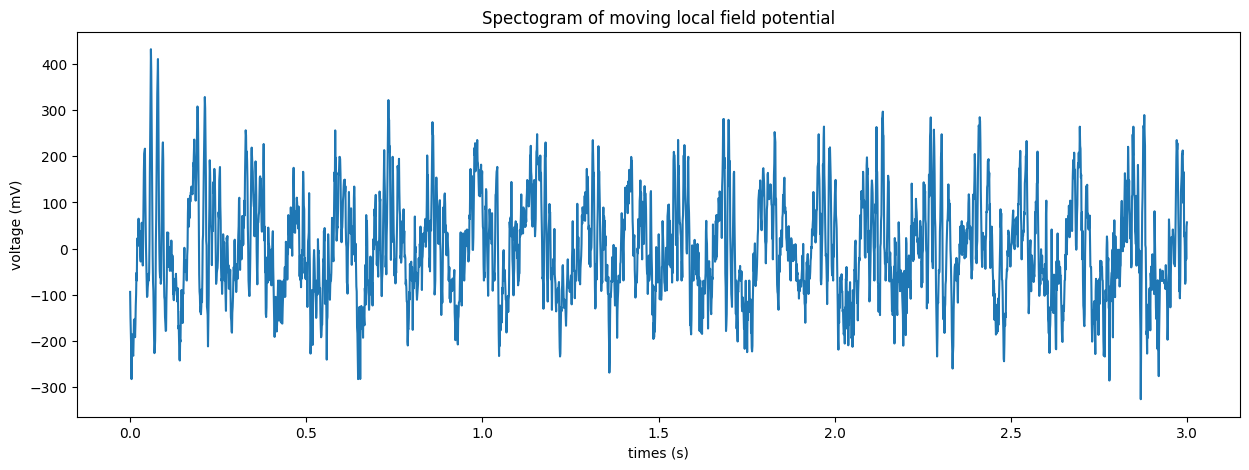

In [7]:
lfp_sig = lfp[:3000] # Capture only the first 3 seconds of the recording
lfp_sig = lfp_sig - np.mean(lfp_sig) # get rid of 0 frequency component

## Spectrogram
plt.figure(figsize=(15,5))
plt.title('Spectogram of moving local field potential')
plt.plot(np.linspace(0,3,3000),lfp_sig)
plt.xlabel('times (s)')
plt.ylabel('voltage (mV)')
plt.show()

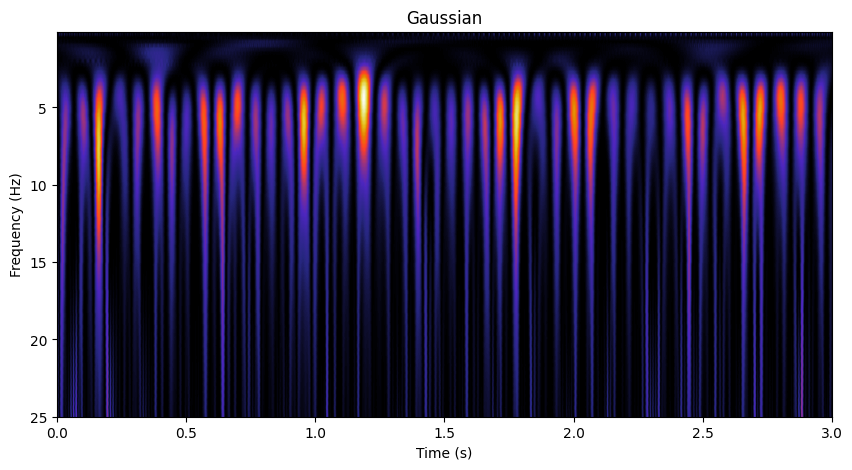

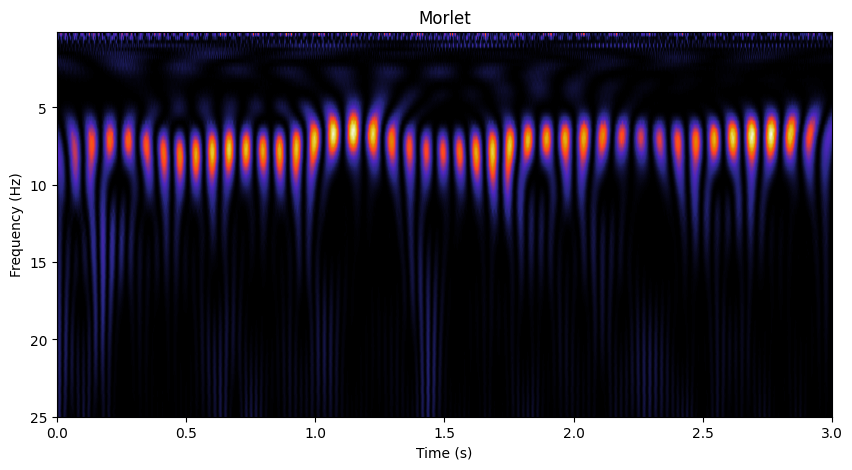

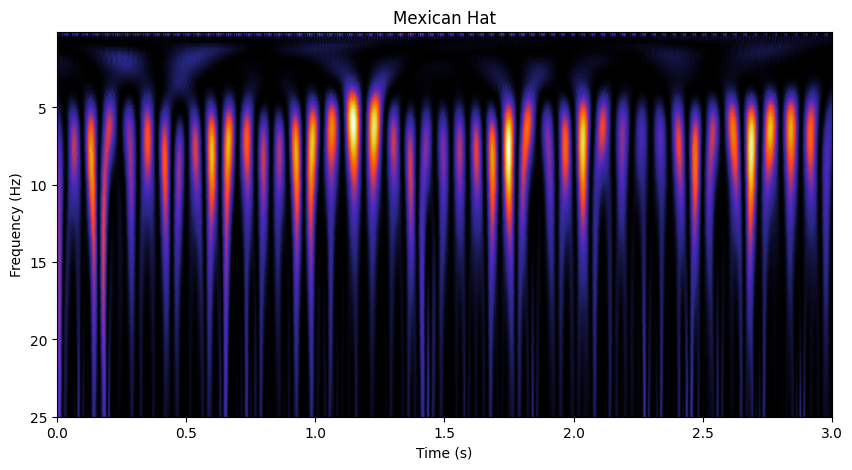

In [8]:
# Frequency range for all the wavelet transforms
frequencies =  np.linspace(0.1,25,100) # Frequencies in the range of 0.1 to 25

## Gaussian wavelet transform
wavelet = 'gaus1'
scales = scale2frequency(wavelet, frequencies/sampling_rate) # Divide frequencies by the sampling such that the scale does not become too small
cwtmatr, _ = cwt(lfp_sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[0,3,frequencies[-1],frequencies[0]], aspect='auto', cmap='CMRmap')
plt.title('Gaussian')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Morlet Wavelet Transform
wavelet = 'morl'
scales = scale2frequency(wavelet, frequencies/sampling_rate) # Divide frequencies by the sampling such that the scale does not become too small
cwtmatr, _ = cwt(lfp_sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[0,3,frequencies[-1],frequencies[0]], aspect='auto', cmap='CMRmap')
plt.title('Morlet')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

## Mexican Hat Wavelet Transform
wavelet = 'mexh'
scales = scale2frequency(wavelet, frequencies/sampling_rate) # Divide frequencies by the sampling such that the scale does not become too small
cwtmatr, _ = cwt(lfp_sig, wavelet=wavelet, scales=scales,
                  sampling_period=1.0)
plt.figure(figsize=(10,5))
plt.imshow(abs(cwtmatr)**2, extent=[0,3,frequencies[-1],frequencies[0]], aspect='auto', cmap='CMRmap')
plt.title('Mexican Hat')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

__Comments:__
- The Gaussian wavelets are constructed with a window function that is given by the derivates of the Gaussian probability density function which is $e^{-x^2/2}$. The decay function applied in the top figure is the first derivate $x\cdot e^{-x^2/2}$
- The Real Morlet Wavelet is a cosine wave multiplied by a Gaussian window. The frequency intensities therefore look like a Gaussian function around ~8 Hz (see middle figure).
- Mexican Hat seems to be a combination of the Gaussian and Morlet Wavelet.

### FPB comments 
COde is OK, however the complex wavelet part is missing which was an important part of the exercise. Grade: 6


## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [9]:
with open('../../AchimBrinkop/Neuro-Analysis/01-local_field_potential/data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


In [10]:
start = 0 #in seconds
end = 100 # in seconds

lfp_sig = lfp[int(start*sampling_rate):int(end*sampling_rate)]
lfp_sig = lfp_sig - np.mean(lfp_sig) # get rid of 0 frequency component
wavelet = 'cmor1.0-1.0'

# Power signal delta frequencies
delta_frequencies =  np.linspace(2,4,30)/sampling_rate
delta_scales = scale2frequency(wavelet, delta_frequencies)
cwtmatr, _ = cwt(lfp_sig, wavelet=wavelet, scales=delta_scales,
                  sampling_period=1.0/sampling_rate)
delta_power = np.mean(abs(cwtmatr)**2,axis=0)

# Power signal theta frequencies
theta_frequencies =  np.linspace(6,10,50)/sampling_rate
theta_scales = scale2frequency(wavelet, theta_frequencies)
cwtmatr, _ = cwt(lfp_sig, wavelet=wavelet, scales=theta_scales,
                  sampling_period=1.0/sampling_rate)
theta_power = np.mean(abs(cwtmatr)**2,axis=0)

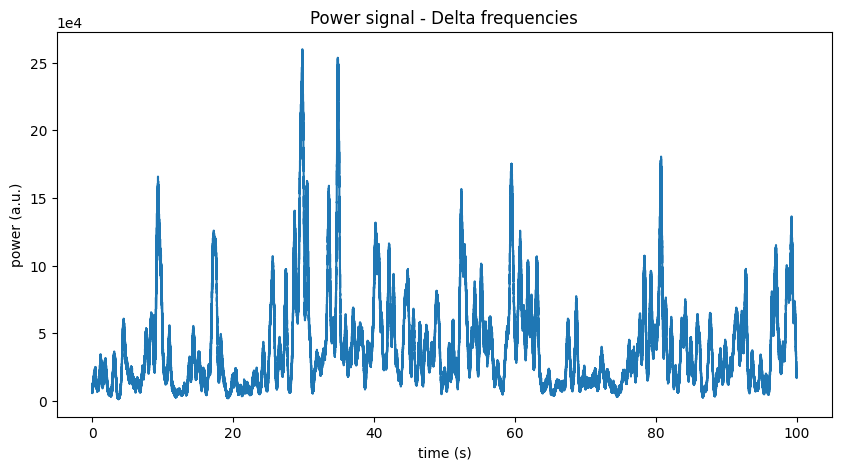

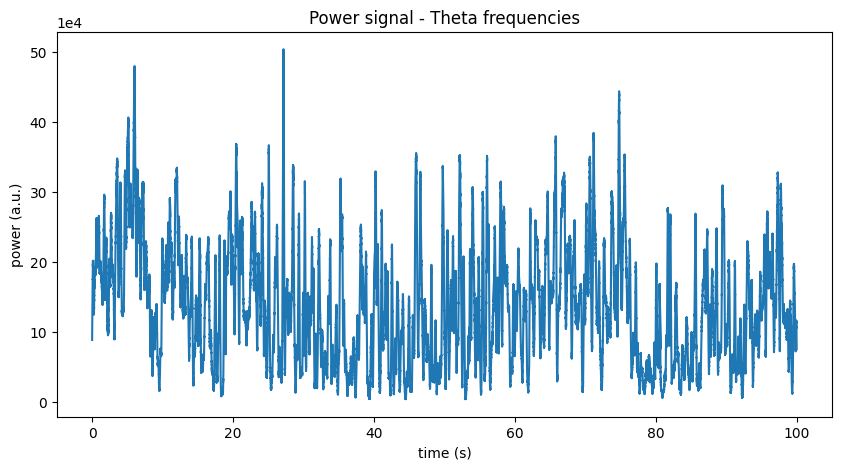

In [12]:
# Delta frequencies
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),delta_power,label='Delta frequencies')
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Power signal - Delta frequencies')
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.show()

# Theta frequencies
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),theta_power,label='Theta frequencies')
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.title('Power signal - Theta frequencies')
plt.ticklabel_format(axis='y', style='sci', scilimits=(4,4))
plt.show()

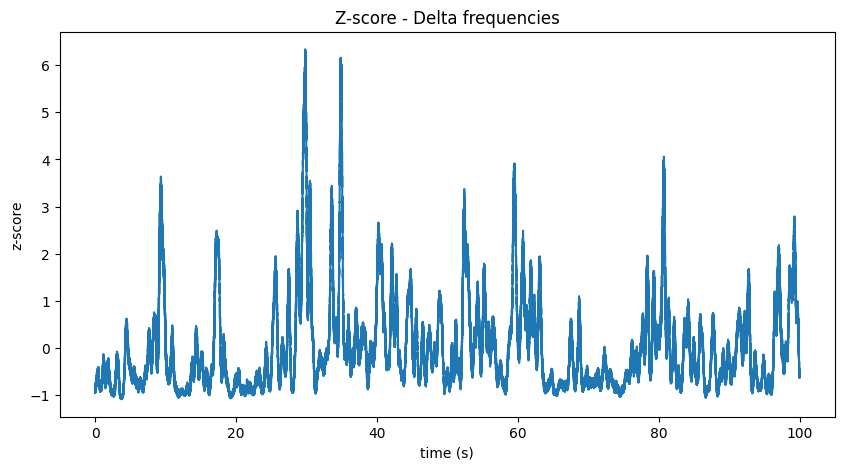

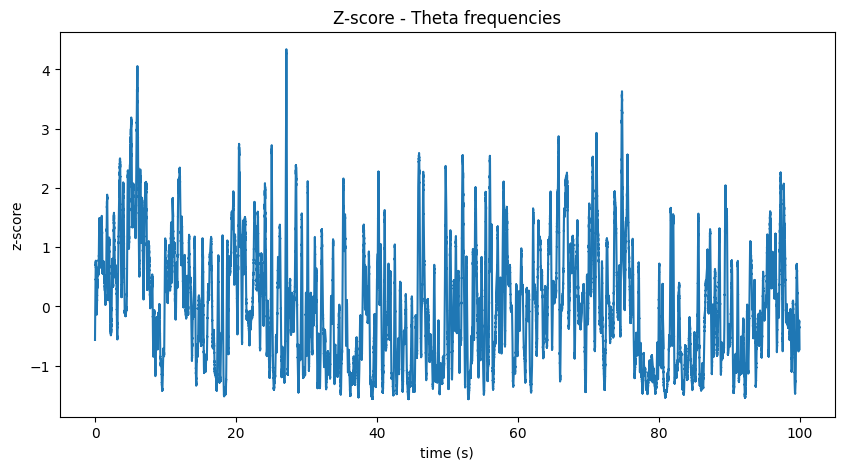

In [14]:
## Z-score for the delta frequencies
zdelta = (delta_power - np.mean(delta_power))/np.std(delta_power)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),zdelta,label='Delta z-score')
plt.xlabel('time (s)')
plt.ylabel('z-score')
plt.title('Z-score - Delta frequencies')
plt.show()

## Z-score for the theta frequencies
ztheta = (theta_power - np.mean(theta_power))/np.std(theta_power)

plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),ztheta,label='Theta z-score')
plt.xlabel('time (s)')
plt.ylabel('z-score')
plt.title('Z-score - Theta frequencies')
plt.show()

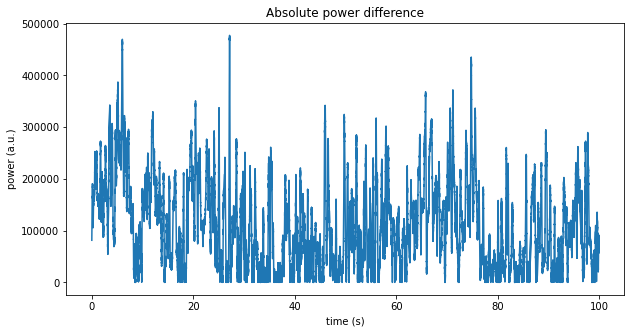

In [34]:
### Compute and plot the power difference (theta_power - delta_power) for the sleep session
# Theta frequencies dominate durring REM sleep
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),abs(theta_power-delta_power))
plt.title('Absolute power difference')
plt.xlabel('time (s)')
plt.ylabel('power (a.u.)')
plt.show()

### FPB comments 
you have to subtract the z-scored powers (otherwise they are not on the same scale) 

In [43]:
REM = []
for i in range(int(len(lfp_sig)/10)):
    if abs(theta_power-delta_power)[i*10]/1000000 < 0.2:
        REM = np.append(REM,0)
    else:
        REM = np.append(REM,1)

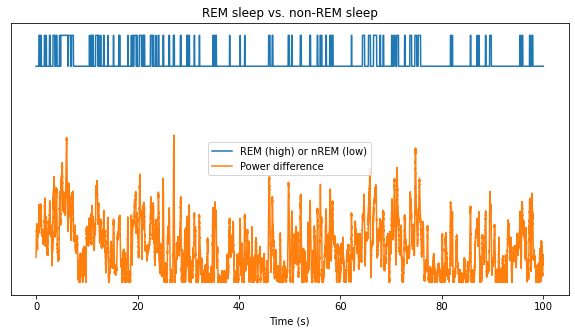

In [67]:
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(REM)),100000*REM+0.7e6,'-',label='REM (high) or nREM (low)')
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),abs(theta_power-delta_power),label='Power difference')
plt.legend()
plt.xlabel('Time (s)')
plt.title('REM sleep vs. non-REM sleep')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.show()

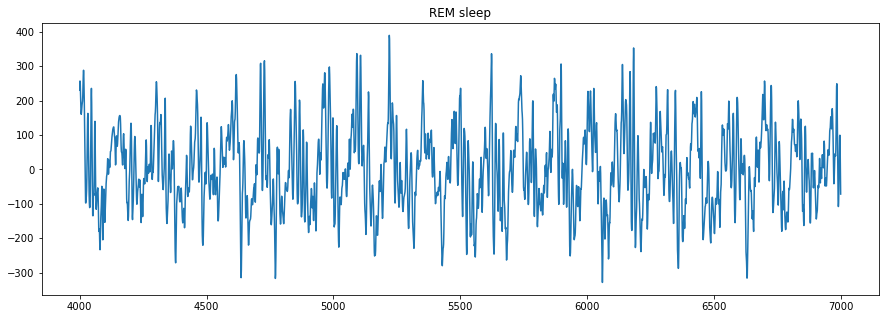

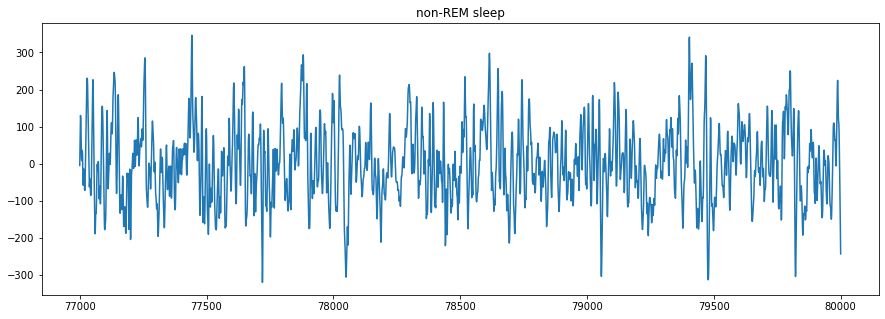

In [70]:
# Bandpass filter
bandpass_filter = butter(filter_order,[1,200],
                btype='band', 
                output='sos', 
                fs=sampling_rate)

# LFP signal with frequencies in the range of 1 and 200 Hz
wideband_lfp = sosfilt(bandpass_filter, lfp_sig)

plt.figure(figsize=(15,5))
plt.plot(np.linspace(4*sampling_rate,7*sampling_rate,3000),wideband_lfp[int((4*sampling_rate)):int((7*sampling_rate))])
plt.title('REM sleep')
plt.show()

plt.figure(figsize=(15,5))
plt.plot(np.linspace(77*sampling_rate,80*sampling_rate,3000),wideband_lfp[int((77*sampling_rate)):int((80*sampling_rate))])
plt.title('non-REM sleep')
plt.show()

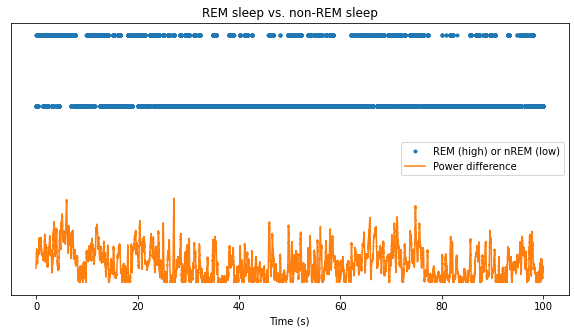

In [74]:
## Changing the threshold:
REM = []
for i in range(int(len(lfp_sig)/10)):
    if abs(theta_power-delta_power)[i*10]/1000000 < 0.15:
        REM = np.append(REM,0)
    else:
        REM = np.append(REM,1)
        
plt.figure(figsize=(10,5))
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(REM)),400000*REM+1e6,'.',label='REM (high) or nREM (low)')
plt.plot(np.linspace(0,len(lfp_sig)/sampling_rate,len(lfp_sig)),abs(theta_power-delta_power),label='Power difference')
plt.legend()
plt.xlabel('Time (s)')
plt.title('REM sleep vs. non-REM sleep')
ax = plt.gca()
ax.get_yaxis().set_visible(False)
plt.show()

In this case the threshold is lowered so the amount of detected REM-sleep is higher. The non-REM sleep seems to consist of more high frequency signals.

### FPB comments 

you get a lot more NREM because before z-scoring delta is much bigger than theta. 
The other point (which we should have emphasized more) is that some smoothing is needed on the statistics in order to get the periods of REM and NREM, which last for several seconds. If you look at your plots of theta and delta, it looks like you have a period of REM between t = 65 s and t = 75 s with strong theta and lower delta. 
Grade: 5